In [19]:
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
alpha = 0.4
optimizer_method = 'L-BFGS-B'
#optimizer_method ='BFGS'
#optimizer_method = 'SLSQP' #each param explodes
#optimizer_method = 'nielder_method'
number_of_restarts = 1
bounds = [(0, 1000), (0, 1000), (0, 1000)] # left r0 was: 0.01, right rc: 100, right c: 100
scale_factor = [1e-4, 1e-4, 1e3] #c before: 10^7
batch_size = 10000
options = {
    'maxiter': 1000,   # Increase the maximum number of iterations
    'disp': True,      # Display progress
    'maxls': 50,       # Increase maximum number of line search steps
    'ftol': 1e-12,     # Reduce the step size for line search
    'gtol': 1e-8,       # Gradient norm must be less than this before successful termination
    'approx_grad': True,
}

In [21]:
current_path = os.getcwd()
print("Current working directory:", current_path)

Current working directory: /mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/notebooks/online_learning/optimizer_experiments


In [22]:
relative_path_ground = os.path.join('..', '..','..', 'data', 'initialization', 'ground_20.csv')
path_ground = utils.get_absolute_path(relative_path_ground)

# Load Dataframe
df = pd.read_csv(path_ground)
    
#v_real = df['voltage'].values
i_real = df['current'].values
#t_real = df['temperature'].values
time = df['time']
    
# Load YAML:
relative_path_grid = os.path.join('..', '..','..', 'data', 'config','grid_parameters')
path_grid = utils.get_absolute_path(relative_path_grid)
grid_parameters = utils.load_from_yaml(path_grid)
    
relative_path_electrical_params = os.path.join('..','..','..','data',
                                                           'initialization','electrical_params')
path_electrical_params = utils.get_absolute_path(relative_path_electrical_params)
electrical_params = utils.load_from_yaml(path_electrical_params)
    
relative_path_thermal_params = os.path.join('..', '..','..', 'data',
                                                           'initialization', 'thermal_params')
path_thermal_params = utils.get_absolute_path(relative_path_thermal_params)
    
thermal_params = utils.load_from_yaml(path_thermal_params)
models_config = [electrical_params, thermal_params]
    
relative_path_battery_options = os.path.join('..', '..','..', 'data',
                                                        'initialization', 'battery_options')
path_battery_options = utils.get_absolute_path(relative_path_battery_options)
    
battery_options = utils.load_from_yaml(path_battery_options)
    
load_var = 'current'
    
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )

reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
    
battery.init({'dissipated_heat' : 0 }) # check if you can remove it
        
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()

#battery_results = battery.get_last_results()
optimizer = Optimizer(models_config=models_config, battery_options=battery_options, load_var=load_var,
                      init_info=reset_info, bounds=bounds, scale_factor=scale_factor, options=options)

In [23]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [24]:
r0 = battery._electrical_model.r0.resistance
rc = battery._electrical_model.rc.resistance
c = battery._electrical_model.rc.capacity
theta_to_get = {'r0':r0,'rc':rc,'c':c}

In [25]:
results = battery.build_results_table()
results = results['operations']
v = results['voltage']
v_real = np.array(v)
v_real = v_real[1:len(v_real)]
t = results['temperature']
t_real = np.array(t)
t_real = t_real[1:len(t_real)]

In [26]:
start = 0
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()
history_theta = list()
loss_history = list()
gradient_history = list()

In [27]:
print(len(i_real))

32796


In [29]:
for k, load in enumerate(i_real):
        elapsed_time += dt
        battery.t_series.append(elapsed_time)
        dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
        if (k % batch_size == 0 and k != 0): #  or grid.is_changed_cell(soc, temp):

                theta = optimizer.step(i_real=i_real[start:k], v_real=v_real[start:k],
                                        t_real=t_real[start:k],optimizer_method= optimizer_method,
                                        alpha=alpha,dt=dt, number_of_restarts= number_of_restarts)

                history_theta.append(theta)
                start = k
                v_optimizer = v_optimizer + optimizer.get_v_hat()
                temp_optimizer = temp_optimizer + optimizer.get_t_hat()
                #loss_history = loss_history + optimizer.get_loss_history()
                #gradient_history = gradient_history + optimizer.get_gradient_history()
                #battery_results = battery.get_last_results(), do I need this ???

                #self.set_theta_parameters(battery=battery, theta=theta)


restart number : 0

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83114D+02    |proj g|=  7.78771D-01
THETA [517.71526598 185.04871791  44.68690655]


At iterate    1    f=  2.82437D+02    |proj g|=  7.68210D-01
the gradient is : [0.7684686352149582, 0.0, 0.0]
THETA [453.88414107 196.88817262  45.40994205]


At iterate    2    f=  2.55789D+02    |proj g|=  1.08346D-01
the gradient is : [0.030581634291593215, 0.0, 0.21470665956258014]
THETA
At iterate    3    f=  2.54281D+02    |proj g|=  1.01920D-01
 [446.33414034 205.24572172  39.41364876]
the gradient is : [0.0, 0.0, 0.18859808506022088]
THETA [440.17909672 218.56637433  29.85873568]


At iterate    4    f=  2.52922D+02    |proj g|=  3.97847D-02
the gradient is : [0.021538713212976287, 0.0, 0.013669148302142274]
THETA [436.32992827 226.89315281  28.66746858]


At iterate    5    f=  2.5266


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


TypeError: can only concatenate list (not "NoneType") to list

In [31]:
print("theta_dt:",theta_to_get)
print("theta_optimizer_one:",history_theta[0])
print("theta_optimizer_two:",history_theta[1])

theta_dt: {'r0': 0.04, 'rc': 0.01, 'c': 10000.0}
theta_optimizer_one: {'r0': 0.04428688228575134, 'rc': 0.0251963713446308, 'c': 37216.84082375688}


IndexError: list index out of range

In [12]:
r0 = []
rc = []
c = []
for theta in history_theta:
    r0.append(theta['r0'])
    rc.append(theta['rc'])
    c.append(theta['c'])
r0 = np.array(r0)
rc = np.array(rc)
c = np.array(c)

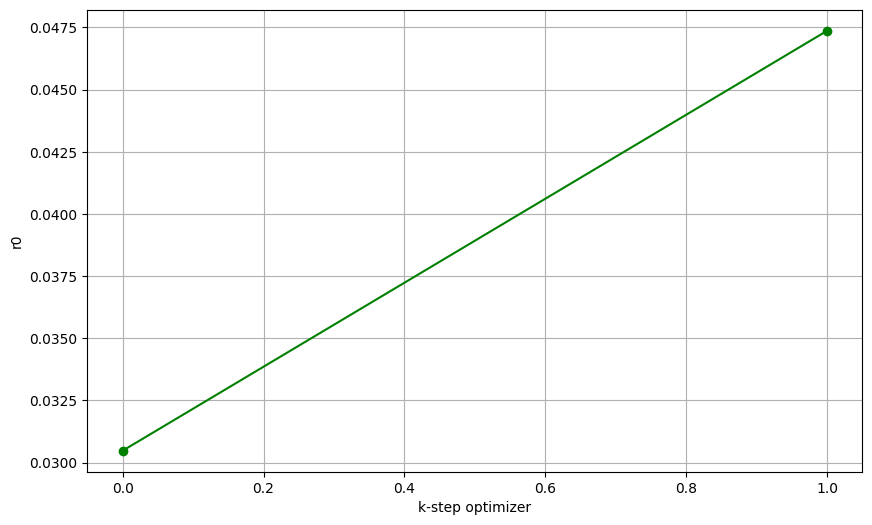

In [13]:
indices = np.arange(len(r0))
plt.figure(figsize=(10, 6))
plt.plot(indices, r0, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('r0')
plt.grid(True)
plt.show()

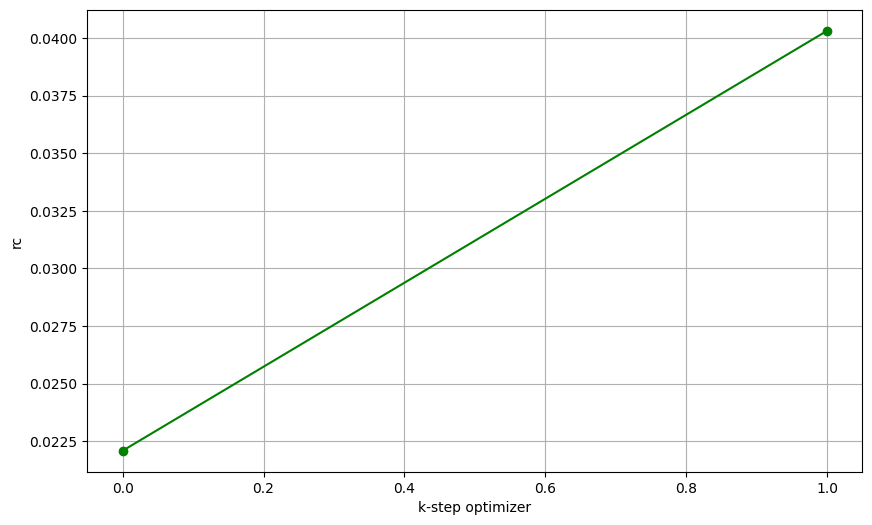

In [14]:
indices = np.arange(len(rc))
plt.figure(figsize=(10, 6))
plt.plot(indices, rc, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('rc')
plt.grid(True)
plt.show()

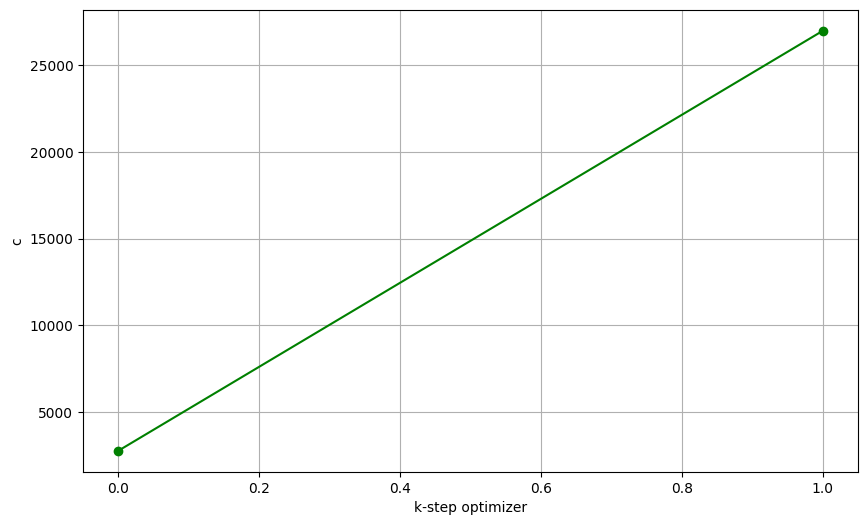

In [15]:
indices = np.arange(len(c))
plt.figure(figsize=(10, 6))
plt.plot(indices, c, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('c')
plt.grid(True)
plt.show()

In [16]:
print(len(history_theta))

2


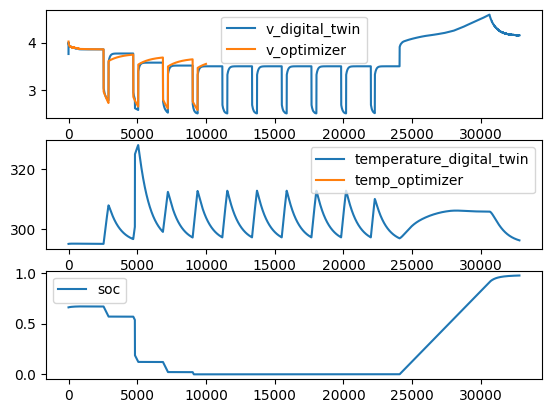

In [30]:
# plotting phase:
results = battery.build_results_table()
results = results['operations']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plot voltage data
ax1.plot(results['voltage'], label='v_digital_twin')
#ax1.plot(df['voltage'][0:len(results['voltage'])], label='ground')
ax1.plot(v_optimizer[0:len(results['voltage'])], label='v_optimizer')
ax1.legend()

# Plot temperature data
ax2.plot(results['temperature'], label='temperature_digital_twin')
#ax2.plot(df['temperature'][0:len(results['temperature'])], label='ground')
ax2.plot(temp_optimizer[0:len(results['temperature'])], label='temp_optimizer')
ax2.legend()

# Plot soc data
ax3.plot(results['soc'], label='soc')
#ax3.plot(df['soc'][0:len(results['temperature'])], label='ground')
ax3.legend()

plt.show()